In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

2025-09-13 09:51:16.290274: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-13 09:51:17.019714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-13 09:51:18.234980: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
(train_images, train_labels), _ = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
train_images = (train_images - 127.5) / 127.5

In [4]:
batch_size = 256
train_ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60_000).batch(batch_size)

I0000 00:00:1757767880.091610    6586 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9696 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


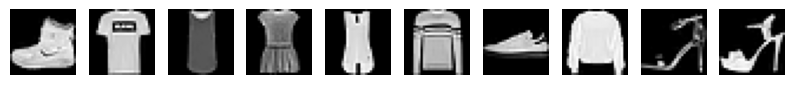

In [5]:
num_images_to_show = 10
plt.figure(figsize=(10, 10))

for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i+1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
def constroi_gerador():
    modelo = Sequential()

    modelo.add(layers.Input(shape=(100,)))
    modelo.add(layers.Dense(7*7*256, use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Reshape((7, 7, 256)))
    modelo.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return modelo

In [8]:
gerador = constroi_gerador()

In [9]:
dimensao_ruido = 100
ruido = tf.random.normal([1, dimensao_ruido])

In [10]:
imagem_gerada = gerador(ruido, training=False)

2025-09-13 09:51:21.225666: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91100


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

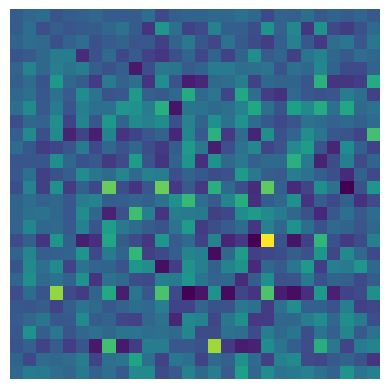

In [11]:
plt.imshow(imagem_gerada[0] * 127.5 + 127.5)
plt.axis('off')

In [12]:
def constroi_discriminador():

    modelo = Sequential()

    modelo.add(layers.Input(shape=(28, 28, 1)))

    modelo.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Dropout(0.3))

    modelo.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Dropout(0.3))

    modelo.add(layers.Flatten())
    modelo.add(layers.Dense(1))

    return modelo

In [13]:
discriminador = constroi_discriminador()
decisao = discriminador(imagem_gerada)
print(decisao)

tf.Tensor([[-0.00292153]], shape=(1, 1), dtype=float32)


In [14]:
cross_entropy =  tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def custo_discriminador(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def custo_gerador(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
otimizador_gerador = tf.keras.optimizers.Adam(1e-4)
otimizador_discriminador = tf.keras.optimizers.Adam(1e-4)

In [18]:
import os

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix =  os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=otimizador_gerador,
    discriminator_optimizer=otimizador_discriminador,
    generator=gerador,
    discriminador=discriminador,
)

In [20]:
epocas = 50
dimensao_ruido = 100
numero_exemplos_treinamento = 16

seed = tf.random.normal([numero_exemplos_treinamento, dimensao_ruido])

In [21]:
@tf.function
def passo_treino(images):
    ruido = tf.random.normal([batch_size, dimensao_ruido])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gerador(ruido, training=True)

        real_output = discriminador(images, training=True)
        fake_output = discriminador(generated_images, training=True)

        gen_loss = custo_gerador(fake_output)
        disc_loss = custo_discriminador(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

    otimizador_gerador.apply_gradients(zip(gradients_of_generator, gerador.trainable_variables))
    otimizador_discriminador.apply_gradients(zip(gradients_of_discriminator, discriminador.trainable_variables))


In [22]:
import time
from IPython.display import clear_output

In [23]:
def gerar_e_salvar_images(modelo, epoca, entrada):
    previsao = modelo(entrada, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(previsao.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(previsao[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoca))
    plt.show()

In [24]:
def treino(dataset, epocas):

    for epoca in range(epocas):
        start = time.time()

        for image_batch in dataset:
            passo_treino(image_batch)

        clear_output(wait=True)
        gerar_e_salvar_images(
            gerador,
            epoca + 1,
            seed,
        )

        if (epoca + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Tempo por época {} é {} s'.format(epoca + 1, time.time()-start))

    clear_output(wait=True)
    gerar_e_salvar_images(
        gerador,
        epoca + 1,
        seed,
    )

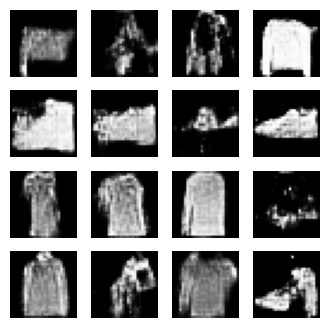

In [25]:
treino(train_ds, epocas)

In [26]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [27]:
gerador.save('modelo_gerador.keras')

In [28]:
from tensorflow.keras.models import load_model

gerador_carregado = load_model('modelo_gerador.keras')

In [29]:
new_noise = tf.random.normal([1, dimensao_ruido])

In [30]:
new_genrated_image = gerador_carregado(new_noise, training=False)


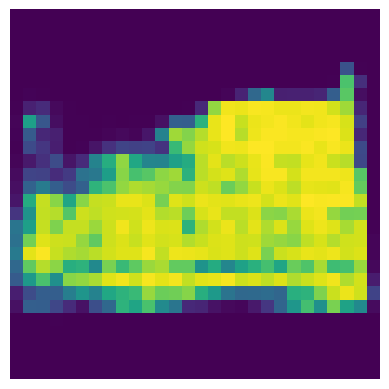

In [31]:
plt.imshow((new_genrated_image[0] * 127.5 + 127.5).numpy())
plt.axis('off')
plt.show()